In [39]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.stats import norm
from scipy.stats import chi2_contingency
from urllib.parse import urlencode

import requests
from tqdm.auto import tqdm
import pingouin as pg
import pandahouse as ph
import warnings
import json

%matplotlib inline
from tqdm.auto import tqdm
#зададим размер графика
sns.set(rc={'figure.figsize' : (10, 6)})

Задание 1. A/B–тестирование

1.1 Условие задачи:

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

Входные данные

1.groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа).

2.groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.2.

3.active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

4.checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.



1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

1 На какие метрики Вы смотрите в ходе анализа и почему?

2 Имеются ли различия в показателях и с чем они могут быть связаны?

3 Являются ли эти различия статистически значимыми?

4 Стоит ли запускать новую механику на всех пользователей?

Недостающая информация

В задании упоминается "в ходе тестирования одной гипотезы...", но о самой гипотезе ничего не сказано.

Ничего неизвестно о периоде проведения эксперимента. Неизвестно в разрезе какого временного показателя (месяц, неделя, день) на наших руках данные.

Неизвестно на что опираются новая/старая механики оплаты услуг на сайте и какие целевые действия производит пользователь перед тем как перейти к оплате.

Неизвестно откуда появились пользователи из таблицы groups_add.csv. Участвовали ли они с самого запуска эксперимента или же были довалены откуда-то отдельно.

Неизвестно каким образом формировалась колонка rev в таблице checks.csv. Это суммы всех оплат каждого пользователя за n-ый период времени или это одна единственная оплата.

Основные гипотезы, которые будем проверять

H0 - Новая механика оплаты услуг на сайте в группе B не отличается от старой механики, оставленной в группе A.

H1 - Новая механика оплаты услуг на сайте в группе B имеет значимые различия в сравнении с механикой в группе A.

Замечания
В связи с тем, что таблица groups_add.csv была передана спустя два дня после получения основных данных, а о происхождении добавленных пользователей мы ничего не знаем, и о периоде проведения эксперимента тоже ничего не знаем, то будем считать, что эти данные собирались из разных источников, но в рамках проведения эксперимента. Поэтому включаем пользователей из таблицы groups_add.csv в АБ-тест.

In [40]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 
sns.set_palette("pastel")
sns.set_style('whitegrid')

In [41]:
def get_dowland(yandex_link):
    base_url     = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'  
    public_key   = yandex_link    
    final_url    = base_url + urlencode(dict(public_key=public_key))                 
    response     = requests.get(final_url) 
    download_url = response.json()['href']                                        
    return pd.read_csv(download_url, sep=";|,", engine ='python')    

In [42]:
df_groups          = get_dowland('https://disk.yandex.ru/d/UhyYx41rTt3clQ')
df_groups_add      = get_dowland('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ') 
df_active_studs = get_dowland('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ') 
df_checks          = get_dowland('https://disk.yandex.ru/d/pH1q-VqcxXjsVA') 

In [43]:
df_groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


<H3>EDA</H3>

<H4>Знакомимся с таблицами</H4>

In [44]:
#Функция для проверки содержимого датасетов

def check_df_values(df, df_name):    
    df_info = pd.DataFrame(columns= ['',
                                     'Записей',
                                     'Уникальных',
                                     'Дублей',
                                     'NaN',
                                     'не NaN',
                                     'Тип'],
                              data=[[f'Сведения о "{df_name}"',
                                     df.shape[0],
                                     '',
                                     '',
                                     '',
                                     '',
                                     '']])
    for col in df.columns:
        df_info = pd.concat([df_info, 
              pd.DataFrame(columns= ['',
                                     'Записей',
                                     'Уникальных',
                                     'Дублей',
                                     'NaN',
                                     'не NaN',
                                     'Тип'],
                              data=[[f'Колонка "{col}"', 
                                     df[col].shape[0], 
                                     df[col].nunique(),
                                     df[col].duplicated().sum(),
                                     df[col].isna().sum(),
                                     df[col].notna().sum(),
                                     df[col].dtype]])],
                              ignore_index=True)
    return df_info

In [45]:
df_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [46]:
check_df_values(df_groups, 'groups')

,,Записей,Уникальных,Дублей,NaN,не NaN,Тип
0,"Сведения о ""groups""",74484,,,,,
1,"Колонка ""id""",74484,74484,0,0,74484,int64
2,"Колонка ""grp""",74484,2,74482,0,74484,object


In [47]:
df_checks.head()

,"""student_id""","""rev"""
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [48]:
check_df_values(df_checks, 'df_checks')

,,Записей,Уникальных,Дублей,NaN,не NaN,Тип
0,"Сведения о ""df_checks""",541,,,,,
1,"Колонка """"student_id""""",541,541,0,0,541,int64
2,"Колонка """"rev""""",541,39,502,0,541,float64


In [49]:
df_active_studs.head()

,"""student_id"""
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [50]:
check_df_values(df_active_studs, 'df_active_studs')

,,Записей,Уникальных,Дублей,NaN,не NaN,Тип
0,"Сведения о ""df_active_studs""",8341,,,,,
1,"Колонка """"student_id""""",8341,8341,0,0,8341,int64


In [51]:
############

Для удобства дальнейшей работы смержим все датасеты в один 

In [75]:
df_active_studs = df_active_students.rename(columns={'"student_id"': 'id'})
df_checks          = df_checks.rename(columns=({'"student_id"': 'id','"rev"': 'revenue'}))

In [76]:
df_checks.head()

,id,revenue
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [77]:
df_active_studs.dtypes

id    int64
dtype: object

In [78]:
#добавляем дополнительные колонки
df_groups_add['added_later'] = True
df_active_studs['active_studs'] = True

#объединяем таблицы в одну общую
df_merged = df_groups.merge(df_groups_add, how='outer', on=['id', 'grp'])
df_merged = df_merged.merge(df_active_studs, how='outer', on=['id'])
df_merged = df_merged.merge(df_checks, how='outer', on=['id'])

In [79]:
df_merged.head()

,id,grp,added_later,active_studs,revenue
0,1489,B,NaN,NaN,NaN
1,1627,A,NaN,True,990.0
2,1768,B,NaN,NaN,NaN
3,1783,B,NaN,NaN,NaN
4,1794,A,NaN,NaN,NaN


In [80]:
#Заполняем NaN значения 

df_merged['added_later'] = df_merged.added_later.fillna(False)
df_merged['active_studs'] = df_merged.active_studs.fillna(False)
df_merged['grp'] = df_merged.grp.astype('string')

In [81]:
df_merged.head()

,id,grp,added_later,active_studs,revenue
0,1489,B,False,False,NaN
1,1627,A,False,True,990.0
2,1768,B,False,False,NaN
3,1783,B,False,False,NaN
4,1794,A,False,False,NaN


Колонку rev заполнять значениями по умолчанию неразумно, т.к. если не нет оплат, то мы не можем присвоить ноль, иначе поплывет средний чек.

<hr>
<b>Проверим объединенную таблицу на корректность</b>

In [82]:
check_df_values(df_merged, 'df_AB_test')

,,Записей,Уникальных,Дублей,NaN,не NaN,Тип
0,"Сведения о ""df_AB_test""",74576,,,,,
1,"Колонка ""id""",74576,74576,0,0,74576,int64
2,"Колонка ""grp""",74576,2,74574,0,74576,string
3,"Колонка ""added_later""",74576,2,74574,0,74576,bool
4,"Колонка ""active_studs""",74576,2,74574,0,74576,bool
5,"Колонка ""revenue""",74576,39,74536,74035,541,float64


In [83]:
df_merged.added_later.unique()

array([False,  True])

In [84]:
df_merged.grp.unique()

<StringArray>
['B', 'A']
Length: 2, dtype: string

In [85]:
df_merged.active_studs.unique()

array([False,  True])

In [86]:
df_merged.describe()

,id,revenue
count,7.457600e+04,541.000000
mean,2.165617e+06,1059.752317
std,2.786959e+06,762.712359
min,1.489000e+03,199.000000
25%,9.197188e+05,290.000000
50%,1.669752e+06,840.000000
75%,3.328121e+06,1900.000000
max,2.010677e+08,4650.000000


In [87]:
# проверим есть пользователи, которые совершили оплаты в день эксперимента но не заходили на платформу
df_merged.query('active_studs == False and revenue.notna()').grp.value_counts()

B    120
A     29
Name: grp, dtype: Int64

In [89]:
#проверим есть ли пользователи, которые были добавлены спустя два дня и проводили оплату
df_merged.query('added_later == True and revenue.notna()').grp.value_counts()

B    1
Name: grp, dtype: Int64

In [90]:
# Это пользователь 74539
df_merged.query('added_later == True and revenue.notna()')

,id,grp,added_later,active_studs,revenue
74539,5740903,B,True,True,1900.0


<hr>
<H4>Вывод о содержимом таблиц</H4>

<ul>
    <li>В рамках проведеня АБ-теста меня интересуют только те пользователи, которые имеются в таблицах active_studs.csv и checks.csv. Это связано с тем, что мы не можем проверить гипотезу эксперимента на пользователях, которые были отобраны для эксперимента, но по сути так в нем и не поучаствовали, т.е. не все пользователи из таблиц groups.csv и groups_add.csv заходили в приложение и тем более, что-то могли оплатить. Я допускаю тот факт, что пользователи, которые не заходили в приложение, но совершили оплату в дни эксперимента, это такие пользователи, у которых настроен автоплатеж или что-то подобное. Но так как мы не знаем на чем основана новая или старая механики оплат, то просто принимаем этот факт как данность и включаем этих пользователей в АБ-тест.</li>
    <li>Следовательно, для проведения эксперимента было выделено 74576 пользователей, из них 8341 заходил в приложение, 541 совершил оплату.</li>
</ul>
<hr>

<b>Отфильтруем пользователей для АБ-теста</b>
<ul>
    <li>Которые заходили в приложение во время эксперимента.</li>
    <li>Которые совершали оплату во время эксперимента.</li>
</ul>

In [91]:
df_AB_test = df_merged.query('active_studs == True or revenue.notna()')
df_AB_test.head()

,id,grp,added_later,active_studs,revenue
1,1627,A,False,True,990.0
10,2085,B,False,True,NaN
12,2215,B,False,True,NaN
39,3185,B,False,False,690.0
43,3391,A,False,True,NaN


In [ ]:
check_df_values(df_AB_test, 'df_AB_test')

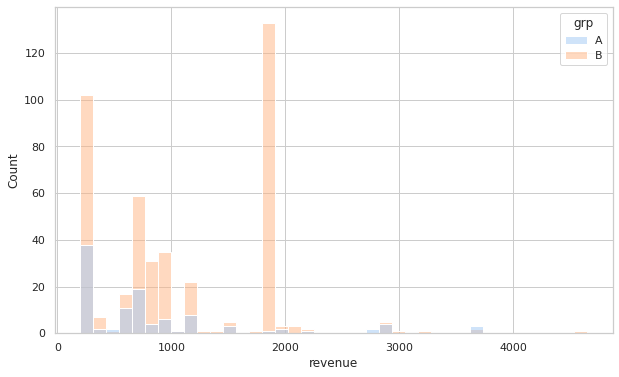

In [92]:
#посмотрим на распределение оплат
sns.histplot(data=df_AB_test, x="revenue", hue='grp', bins=39)

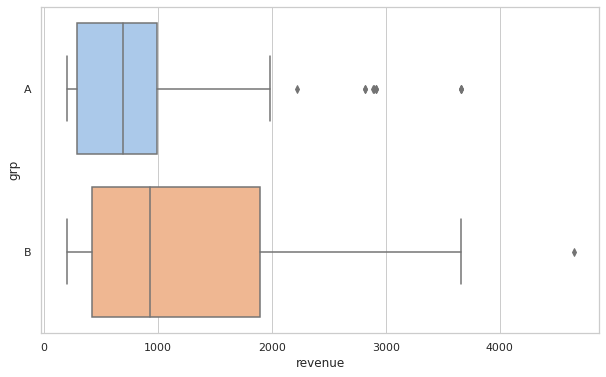

In [93]:
sns.boxplot(data=df_AB_test, x="revenue", y="grp")

<p>Распределения оплат выглядят явно не равномерными, не унимодальными, имеют выбросы.

<b>Посмотрим на то, какие бизнес метрики мы можем извлечь из данных</b>

In [104]:
metrics = pd.DataFrame()
metrics['users'] = df_AB_test.groupby('grp').id.count()
metrics['clients'] = df_AB_test.groupby('grp').revenue.count()
metrics['users_%'] = round(df_AB_test.grp.value_counts(normalize=True)*100,2)
metrics['clients_%'] = round(df_AB_test.groupby('grp').revenue.count() / df_AB_test.revenue.count()*100,2)
metrics['CR_to_clients'] = df_AB_test.groupby('grp').revenue.count() / df_AB_test.groupby('grp').id.count()
metrics['mean_revenue'] = df_AB_test.groupby('grp').revenue.mean()
metrics['repeat_purchases'] = df_AB_test.groupby('grp').revenue.count() / df_AB_test.query('revenue.notna()').groupby('grp').revenue.count()
metrics['arppu'] = metrics['repeat_purchases'] * df_AB_test.groupby('grp').revenue.mean()
metrics['arpu'] = metrics['CR_to_clients']*metrics['arppu']
metrics

,users,clients,users_%,clients_%,CR_to_clients,mean_revenue,repeat_purchases,arppu,arpu
A,1567,107,18.46,19.78,0.068283,860.710280,1.0,860.710280,58.772176
B,6923,434,81.54,80.22,0.062690,1108.824893,1.0,1108.824893,69.511773


<H3>Замечания</H3>
<ul>
    <li>Группы поделены не равномерно между собой. У группы <i>B</i> явный перекос в бОльшую сторону по количеству пользователей. Мною принято решение, что при бутстрапировании я буду использовать количество записей в подвыборах в соответствии с количеством записей в группе А (1567), чтобы избежать сильных различий между распределениями. В таком случае, если различия между группами действительно имеются, то мы все равно это заметим.</li>
    <li>Конверсия в покупателя у группы А выше, чем у группы Б. Не исключено, что причина в том, что группа А меньше по к-ву пользователей, чем группа Б.</li>
    <li>Как видим, метрика ARPPU ожидаемо равна среднему чеку, т.к. на каждого платящего пользователя приходится по одной покупке (repeat_purchases = 1, что означает, что повторных покупок не было).</li>
    <li>Для корректного проведения АБ-теста группы должны быть поделены поровну. В связи с этим будем использовать бутсрап.</li>
    <li>Для теста остаются две метрики - это средний чек и ARPU. Проведем бутстрап тесты по этим метрикам и посмотрим на результаты.</li>
    <li>Для корректного проведения теста по среднему чеку в бутстрапе мы будем игнорировать значения NaN. Для подсчета ARPU выделена отдельная функция, чтобы ARPU считалось по подвыборкам.</li>
</ul>
<p>

In [ ]:
def bootstrap(
    df_1, # ДФ первой выборки
    df_2, # ДФ второй выборки
    col_1, #название колонки первой выборки
    col_2, #название колонки второй выборки
    sample_count_1 = 0, #количество наблюдений для подвыборок
    sample_count_2 = 0, #количество наблюдений для подвыборок
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = 'mean', # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    replace = True, #параметр возвращения
    max_len = True
):
    from scipy.stats import norm
    
    if sample_count_1 == 0:
        sample_count_1 = len(df_1[col_1])
    
    if sample_count_2 == 0:
        sample_count_2 = len(df_2[col_2])
    if max_len:
        boot_len = max([sample_count_1, sample_count_2])
    else:
        boot_len = min([sample_count_1, sample_count_2])
    
    boot_data = []
    smpl_1_data = []
    smpl_2_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        if statistic == 'arpu':
            samples_1 = arpu(df_1.sample(boot_len, replace=replace))
            samples_2 = arpu(df_2.sample(boot_len, replace=replace))            
        else:
            samples_1 = np.nanmean(df_1[col_1].sample(boot_len, replace=replace).values)
            samples_2 = np.nanmean(df_2[col_2].sample(boot_len, replace=replace).values)
        
        
        boot_data.append(samples_1-samples_2)
        smpl_1_data.append(samples_1)
        smpl_2_data.append(samples_2)
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.nanmean(boot_data), 
        scale = np.nanstd(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.nanmean(boot_data), 
        scale = np.nanstd(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    print('pvalue = ', p_value)
       
    return {"boot_data" : boot_data, 
            "quants" : quants, 
            "p_value" : p_value,
           "smpl_1_data" : smpl_1_data,
           "smpl_2_data" : smpl_2_data}


def arpu(df):
    rep_pur = df.rev.count() / df.query('rev.notna()').rev.count()
    arppu = rep_pur * df.rev.mean()
    return (df.rev.count() / df.id.count())*arppu

In [ ]:
#бутстрап по среднему чеку, max_len = False
booted_data = bootstrap(df_1 = df_AB_test.query('grp == "A"'), col_1 = 'rev',
                        df_2 = df_AB_test.query('grp == "B"'), col_2 = 'rev',
                        boot_it = 5000,
                        statistic = 'mean',
                        max_len = False)

<H4>Вывод по бутстрапу по среднему чеку</H4>
<ul>
    <li>На графике выше можно увидеть, что распределения разниц между средними лишь слегка пересекают отметку 0. Это означает, что очень малое количество наблюдений из двух выборок пересекаются между собой.</li>
    <li>pvalue < уровня значимости 0.05. Это дает нам основания ОТВЕРГНУТЬ нулевую гипотезу.</li>
    <li>Т.к. на вход мы подавали первым ДФ по группе А, то согласно заданным расчетам (группа А - группа Б) по группе А значения среднего чека менньше, чем в группе Б. Ниже приведен график распределения разниц между средними, чтобы убедиться в этом утверждении.</li>
</ul>

In [ ]:
sns.histplot(booted_data['smpl_1_data'], color='r')
sns.histplot(booted_data['smpl_2_data'], color='b')

In [ ]:
#бутстрап по arpu, max_len = False
booted_data = bootstrap(df_1 = df_AB_test.query('grp == "A"'), col_1 = 'rev',
                        df_2 = df_AB_test.query('grp == "B"'), col_2 = 'rev',
                        boot_it = 5000,
                        statistic = 'arpu',<H4>Вывод по бутстрапу по ARPU</H4>
<ul>
    <li>Как видим, при сравнении распределений ARPU pvalue превысил уровень значимости в 0.05, что не дает нам основания отвергнуть нулевую гипотезу. Вероятноть того, что среднее значение ARPU группы Б примет среднее значение ARPU группы А достаточно велика.</li>
</ul>
<p>Ниже приведен график распределения разниц ARPU
                        max_len = False)

<H4>Вывод по бутстрапу по ARPU</H4>
<ul>
    <li>Как видим, при сравнении распределений ARPU pvalue превысил уровень значимости в 0.05, что не дает нам основания отвергнуть нулевую гипотезу. Вероятноть того, что среднее значение ARPU группы Б примет среднее значение ARPU группы А достаточно велика.</li>
</ul>
<p>Ниже приведен график распределения разниц ARPU

In [ ]:
sns.histplot(booted_data['smpl_1_data'], color='r')
sns.histplot(booted_data['smpl_2_data'], color='b')

<p>Но несмотря на то, что пересечения разниц ARPU расположены близко друг к другу, в большинстве наблюдений ARPU в группе Б все таки выше, чем в группе А.
<p>Напомню, что максимальное количество наблюдений бралось по количеству записей в группе А. Напоследок проведем еще один бутстрап тест, но по макс. к-ву наблюдений, взятых по группе Б.

In [ ]:
#бутстрап по arpu, max_len = True
booted_data = bootstrap(df_1 = df_AB_test.query('grp == "A"'), col_1 = 'rev',
                        df_2 = df_AB_test.query('grp == "B"'), col_2 = 'rev',
                        boot_it = 5000,
                        statistic = 'arpu',
                        max_len = True)

In [ ]:
sns.histplot(booted_data['smpl_1_data'], color='r')
sns.histplot(booted_data['smpl_2_data'], color='b')

<p>Ввиду того, что в группе Б больше уникальных записей в сравнении с группой А, то, конечно, различия уже более явно прослеживаются. pvalue не превысил уровень значимости в 0.05

<hr>
<H3>ВЫВОД ПО ПРОВЕДЕНИЮ АБ-ТЕСТА</H3>

<H4>Основные гипотезы</H4>
<ul>
    <li>H0 - Новая механика оплаты услуг на сайте в группе <i>B</i> не отличается от старой механики, оставленной в группе <i>A</i>.</li>
    <li>H1 - Новая механика оплаты услуг на сайте в группе <i>B</i> имеет значимые различия в сравнении с механикой в группе <i>A</i>.</li>
</ul>
<hr>
<ul>
    <li>Бутстрап по среднему чеку показал pvalue < 0.05. Это <b>дает нам основания отвергнуть нулевую гипотезу.</b></li>
    <li>Бутстрап по ARPU и к-ву наблюдений в подвыборках равному 1567 наблюдений показал pvalue > 0.05. Это <b>не дало нам основания отвергнуть</b> нулевую гипотезу.</li>
    <li>Бутстрап по ARPU и к-ву наблюдений в подвыборках равному 6923 наблюдений показал pvalue < 0.05. <b>Есть основания отвергнуть</b> нулевую гипотезу.</li>
    <li>Визуализируя разницу распределений метрик мы увидели явное различие между группами, где показатели распределений в группе Б лучше, чем в группе А во всех трех тестах.</li>  
    <li><b>Согласно проведенным тестам имеет смысл применить новую механику оплаты услуг на всех пользователей. Но в идеале нужно было выделить больше пользователей для группы А, потому что из-за малого количества уникальных пользователей в группе А мы можем столкнуться с ситуацией, когда тесты показали значимые различия, а в генеральной совокупности эти различия могут поменяться местами или их попросту может не оказаться.</b></li>
</ul>
<hr>

In [ ]:
#################

<H2>Задание 2. SQL</H2>

<H3>2.1.1. Условие</H3>
<ul>
    <li>Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".</li>
    <li>Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц <b>правильно</b> решил 20 горошин.</li>
</ul>

<H3>2.1.2. Задача</H3>
<ul>
    <li>Дана таблица default.peas.</li>
    <li>Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.</li>
    <li>NB! Под очень усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.</li>
</ul>

In [ ]:
import pandahouse as ph

In [ ]:
#задаем параметры соединения с базой данных
connection = {'host': 'http://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [ ]:
#пишем запрос к базе данных
query = '''
        SELECT 
            COUNT(students_count) AS students_count
        FROM
            (SELECT
              COUNT(st_id) AS students_count
            FROM
              default.peas
            WHERE
              toStartOfMonth(timest) = (SELECT toStartOfMonth(MAX(timest)) FROM default.peas)
            GROUP BY st_id
            HAVING SUM(correct) >= 20) AS t
        '''
#сохраняем резуьтат запроса в переменную
students_count = ph.read_clickhouse(query=query, connection=connection)
students_count

<H3>Ответ</H3>
<ul>
    <li>136 студентов выполнили больше 20 горошин за последний месяц</li>
</ul>
<hr>

<H3>2.2.1. Условие</H3>
<ul>
    <li>Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.
</ul>   

<H3>2.2.2 Задача</H3>

<ul>
    <li>Даны таблицы: default.peas, default.studs, default.final_project_check</li>
</ul>

<p>Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:
<ul>
    <li>ARPU</li>
    <li>ARPAU</li>
    <li>CR в покупку</li>
    <li>СR активного пользователя в покупку</li>
    <li>CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике</li>
    <li>ARPU считается относительно всех пользователей, попавших в группы.</li>
</ul>
<p>Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
<p>Активным по математике считается пользователь,

In [ ]:
#пишем запрос к базе данных
query = '''
        SELECT
            test_grp,
            ROUND(SUM(is_client) / COUNT(DISTINCT user) * SUM(all_money) / SUM(is_client),2) AS ARPU,
            ROUND(SUM(all_money) / SUM(is_active_user),2) AS ARPAU,
            ROUND(SUM(is_client) / COUNT(DISTINCT user) * 100,2) AS CR,
            ROUND(SUM(is_client * is_active_user) / SUM(is_active_user) * 100, 2) AS active_CR,
            ROUND(SUM(is_math_client * is_math_active_user) / SUM(is_math_active_user) * 100,2) AS math_CR
        FROM
            (
            SELECT 
                s.test_grp as test_grp,
                s.st_id AS user,
                CAST(COALESCE(SUM(all_money), 0) AS FLOAT) AS all_money,
                CAST(COALESCE(MAX(is_client), 0) AS FLOAT) AS is_client,
                CAST(COALESCE(MAX(is_math_client), 0) AS FLOAT) AS is_math_client,
                CAST(COALESCE(MAX(is_active_user), 0) AS FLOAT) AS is_active_user, 
                CAST(COALESCE(MAX(is_math_active_user), 0) AS FLOAT) AS is_math_active_user
            FROM default.studs AS s
            LEFT JOIN (
                SELECT 
                    st_id AS client,
                    1 AS is_client,
                    money AS all_money,
                    CASE WHEN subject = 'Math' THEN
                        1
                    ELSE
                        0
                    END AS is_math_client
                FROM default.final_project_check) AS c
            ON s.st_id = c.client
            LEFT JOIN (
                SELECT
                    st_id AS active_user,
                    1 AS is_active_user
                FROM default.peas
                GROUP BY st_id
                HAVING SUM(correct) > 10) AS active_users
            ON s.st_id = active_users.active_user
            LEFT JOIN (
                SELECT
                    st_id AS math_active_user,
                    1 AS is_math_active_user
                FROM default.peas
                WHERE subject = 'Math'
                GROUP BY st_id
                HAVING SUM(correct) > 1) AS active_maths
            ON s.st_id = active_maths.math_active_user
            GROUP BY test_grp, user
        ) AS t
        GROUP BY test_grp
        '''
#сохраняем результат запроса в переменную
stud_metrics = ph.read_clickhouse(query=query, connection=connection)
stud_metrics

<H2>Задание 3. Python</H2>
<H3>3.1 Задача</H3>
<ol>
<li>Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.</li>
<li>Реализуйте функцию, которая будет строить графики по получаемым метрикам.</li>
</ol>

In [116]:
def get_metrics(add = None, #ДатаФрейм
                keys=['id', 'grp'], #ключи, по которым нужно объединить ДатаФрейм с основной таблицей
                rename_columns = {'student_id':'id'} #колонки, которые нужно переименовать для корректного объединения
               ):
    import pandas as pd
    groups          = get_dowland('https://disk.yandex.ru/d/UhyYx41rTt3clQ')
    groups_add      = get_dowland('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ') 
    active_studs = get_dowland('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ') 
    checks          = get_dowland('https://disk.yandex.ru/d/pH1q-VqcxXjsVA') 
    
    #переименуем колонки для объединенения по ключам    
    active_studs = df_active_students.rename(columns={'"student_id"': 'id'})
    checks          = df_checks.rename(columns=({'"student_id"': 'id','"rev"': 'revenue'}))    
    
    
    #добавляем дополнительную колонку
    active_studs['active_studs'] = True

    #объединяем таблицы в одну общую
    merged = groups.merge(active_studs, how='outer', on=['id'])
    merged = merged.merge(checks, how='outer', on=['id'])
    
    #если в параметр add была передана таблица
    if add is not None:
        add = add.rename(columns=rename_columns)
        merged['added_later'] = True #добавляем дополнительную колонку
        merged = merged.merge(add, how='outer') #присоединяем таблицу к общей
        merged['added_later'] = merged.added_later.fillna(False) #Заполняем NaN значения значениями по умолчанию
    
    #Заполняем NaN значения значениями по умолчанию
    merged['active_studs'] = merged.active_studs.fillna(False)

    #присваиваем колонке grp тип string
    merged['grp'] = merged.grp.astype('string')
    
    #отфильтровываем только активных пользователей и оплативших
    #!!!раскомментировать при необходимости
    #merged = merged.query('active_studs == True or rev.notna()')
    
    df_result = pd.DataFrame()
    df_result['users'] = merged.groupby('grp').id.count()
    df_result['clients'] = merged.groupby('grp').revenue.count()
    df_result['users_%'] = round(merged.grp.value_counts(normalize=True)*100,2)
    df_result['clients_%'] = round(merged.groupby('grp').revenue.count() / merged.revenue.count()*100,2)
    df_result['CR_to_clients'] = merged.groupby('grp').revenue.count() / merged.groupby('grp').id.count()
    df_result['mean_revenue'] = merged.groupby('grp').revenue.mean()
    df_result['repeat_purchases'] = merged.groupby('grp').revenue.count() / merged.query('revenue.notna()').groupby('grp').revenue.count()
    df_result['arppu'] = df_result['repeat_purchases'] * merged.groupby('grp').revenue.mean()
    df_result['arpu'] = df_result['CR_to_clients']*df_result['arppu']
    df_result = df_result.reset_index().rename(columns={'index' : 'grp'})
    
    return {"metrics" : df_result, 
            "data_frame" : merged}

In [117]:
m = get_metrics()

In [118]:
m['metrics']

,grp,users,clients,users_%,clients_%,CR_to_clients,mean_revenue,repeat_purchases,arppu,arpu
0,A,14671,107,19.7,19.78,0.007293,860.710280,1.0,860.710280,6.277418
1,B,59813,433,80.3,80.04,0.007239,1106.997699,1.0,1106.997699,8.013810


In [119]:
m['data_frame']

,id,grp,active_studs,revenue
0,1489,B,False,NaN
1,1627,A,True,990.0
2,1768,B,False,NaN
3,1783,B,False,NaN
4,1794,A,False,NaN
...,...,...,...,...
74492,5740903,<NA>,True,1900.0
74493,5760471,<NA>,True,NaN
74494,5728431,<NA>,True,NaN
74495,5723648,<NA>,True,NaN


In [120]:
def barplot_metrics(df):
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.tight_layout(h_pad=5)
    sns.barplot(y='users', x="grp", data=df, ax=axs[0, 0]).set_title('Users')
    sns.barplot(y='clients', x="grp", data=df, ax=axs[0, 1]).set_title('Clients')
    sns.barplot(y='CR_to_clients', x="grp", data=df, ax=axs[0, 2]).set_title('CR_to_clients')
    sns.barplot(y='mean_revenue', x="grp", data=df, ax=axs[1, 0]).set_title('Mean_Revenue')
    sns.barplot(y='arppu', x="grp", data=df, ax=axs[1, 1]).set_title('ARPPU')
    sns.barplot(y='arpu', x="grp", data=df, ax=axs[1, 2]).set_title('ARPU')
    
    plt.show()

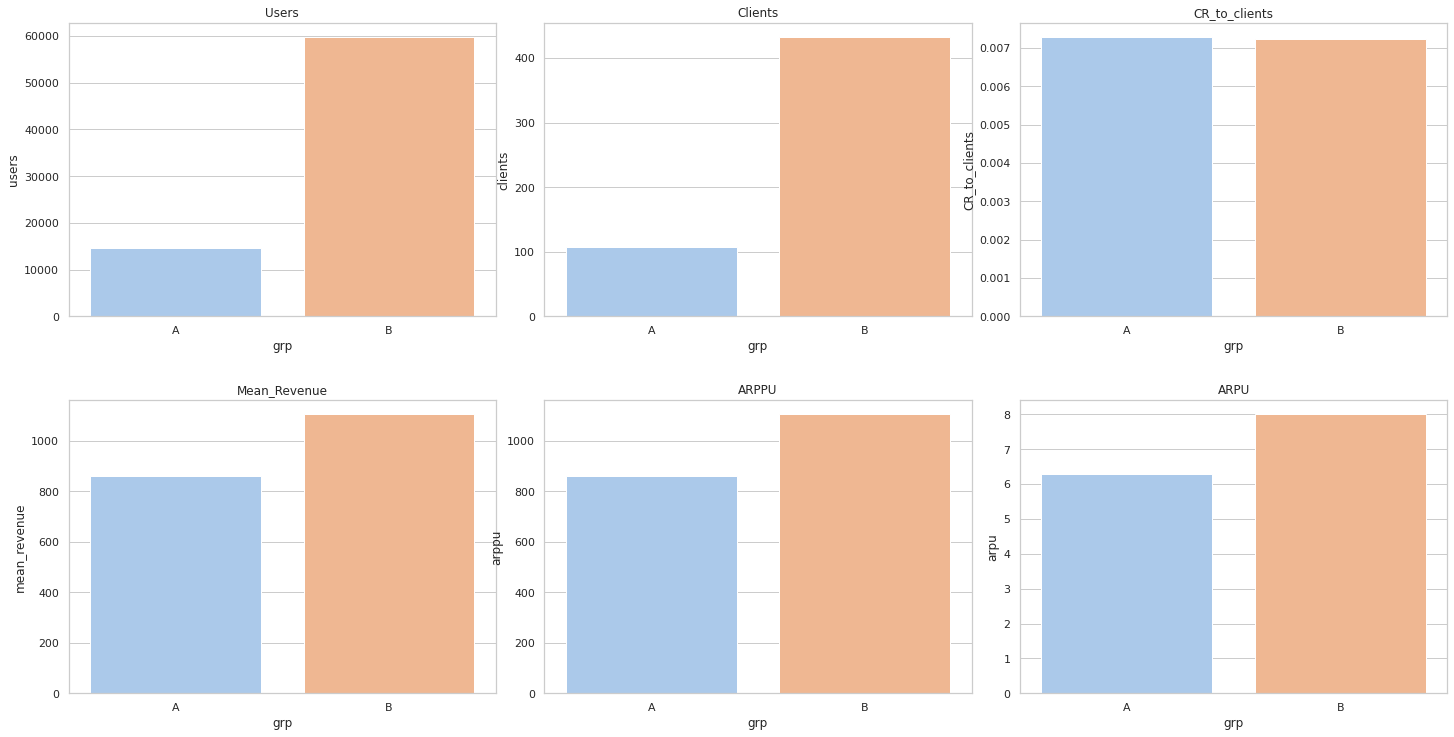

In [121]:
barplot_metrics(m['metrics'])